In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
import corner
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2  # Import L2 regularization
from sklearn.preprocessing import StandardScaler
import joblib

2024-04-29 11:17:55.199857: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-29 11:17:57.614143: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-29 11:17:57.629783: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-29 11:18:00.478612: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Load and split the dataset

In [2]:
data = pd.read_csv('Alignment-1-Learning.csv')

In [3]:
data.head()

,mH1,mH2,mH3,mA1,mA2,mC1,mC2,TanBeta1,TanBeta2,TanAlpha4,TanGamma1,TanGamma2,TanAlpha1,TanAlpha2,Output
0,125.0,389.681890,266.205554,357.716926,216.548541,437.974724,291.549211,1.825617,0.708838,5.560399,21.627008,24.836633,1.825617,0.708838,1
1,125.0,466.478864,389.569317,402.965051,380.172764,364.184617,381.934382,1.054113,0.609084,10.036226,20.546985,15.891286,1.054113,0.609084,1
2,125.0,220.948750,486.689377,537.099375,320.173513,243.467599,406.498383,1.303290,0.919230,13.261847,23.903331,21.670848,1.303290,0.919230,1
3,125.0,328.343580,323.472676,221.752325,348.389320,487.707855,305.971767,0.793804,0.669176,11.678012,12.508026,14.745824,0.793804,0.669176,1
4,125.0,335.247929,211.280269,206.867278,340.005918,207.546645,227.085078,2.043520,1.108583,16.270581,13.387200,20.521982,2.043520,1.108583,1


In [4]:
#check for any empty cell in the database
data.isna().sum()

mH1          0
mH2          0
mH3          0
mA1          0
mA2          0
mC1          0
mC2          0
TanBeta1     0
TanBeta2     0
TanAlpha4    0
TanGamma1    0
TanGamma2    0
TanAlpha1    0
TanAlpha2    0
Output       0
dtype: int64

In [5]:
#shuffle the dataframe

data_sh = data.sample(frac = 1.0, random_state = 13)

#reset the index

data_sh = data_sh.reset_index(drop=True)

In [6]:
#put feature variable to X and target variable to Y

X = data_sh.drop('Output', axis = 1)
Y = data_sh['Output']

In [7]:
# data preprocessing
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

column_names = ['mH1','mH2','mH3','mA1','mA2','mC1','mC2','TanBeta1','TanBeta2','TanAlpha4','TanGamma1','TanGamma2','TanAlpha1','TanAlpha2']

X = pd.DataFrame(X_scaled, columns=column_names)

In [8]:
scaler_filename = "Alignment1-scaler-2.save"
joblib.dump(scaler, scaler_filename)

['Alignment1-scaler-2.save']

In [8]:
#Split into train data and test data

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.92, random_state = 13)

#Split the training data further into labeled and unlabeled dataset

X_labeled, X_unlabeled, Y_labeled, Y_unlabeled = train_test_split(X_train, Y_train, test_size = 0.9997, random_state = 13)

In [9]:
print(f"Total Number of datapoints: {len(X)}")
print(f"Number of labeled datapoints: {len(X_labeled)}")
print(f"Number of unlabeled datapoints: {len(X_unlabeled)}")
print(f"Number of test datapoints: {len(X_test)}")

Total Number of datapoints: 116275
Number of labeled datapoints: 2
Number of unlabeled datapoints: 9300
Number of test datapoints: 106973


In [10]:
frac_unlabeled = Y_unlabeled.sum()/len(Y_unlabeled)
frac_labeled = Y_labeled.sum()/len(Y_labeled)
frac_test = Y_test.sum()/len(Y_test)

In [11]:
print(f"Fraction of allowed points in labeled dataset: {frac_labeled}")
print(f"Fraction of allowed points in unlabeled dataset: {frac_unlabeled}")
print(f"Fraction of allowed points in test dataset: {frac_test}")

Fraction of allowed points in labeled dataset: 0.5
Fraction of allowed points in unlabeled dataset: 0.44881720430107525
Fraction of allowed points in test dataset: 0.4403073672795939


## Neural Network Model 1

In [12]:
# Set random seeds for reproducibility
seed_value = 13
tf.random.set_seed(seed_value)
np.random.seed(seed_value)

import random
random.seed(seed_value)

In [13]:
#define your model
model = keras.Sequential()

# Add input layer with 14 input parameters
model.add(layers.Input(shape=(X.shape[1],)))

model.add(layers.Dense(128, kernel_regularizer=l2(0.001)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.6))

model.add(layers.Dense(32, kernel_regularizer=l2(0.001)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.6))

model.add(layers.Dense(64, kernel_regularizer=l2(0.001)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.6))

model.add(layers.Dense(1, activation = 'sigmoid'))

custom_learning_rate = 0.001  

# Compile the model with a custom learning rate
custom_optimizer = tf.keras.optimizers.Adam(learning_rate=custom_learning_rate)
model.compile(loss='binary_crossentropy', optimizer=custom_optimizer)

# Display the model summary to see the architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1920      
                                                                 
 batch_normalization (Batch  (None, 128)               512       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 128)               0         
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 32)                4128      
                                                                 
 batch_normalization_1 (Bat  (None, 32)                128       
 chNormalization)                                       

## Active Learning Loop

In [14]:
#active learning loop
num_iterations = 36

num_it_array = np.arange(1,num_iterations+2,1)
accuracy_array = np.zeros(num_iterations+1)
precision_array = np.zeros(num_iterations+1)
recall_array = np.zeros(num_iterations+1)
f1_array = np.zeros(num_iterations+1)

for iteration in range(num_iterations):
    #Train the model
    model.fit(X_labeled,Y_labeled, epochs=150, batch_size=32, verbose=0)
    
    #Get model predictions on the test data
    Y_pred_test = model.predict(X_test, verbose=0).ravel()   
    
    #Convert the predictions into binary
    Y_pred_binary = (Y_pred_test > 0.9).astype(int)
    
    #Calculate accuracy,precision,recall and F1 Score on the test set
    accuracy = accuracy_score(Y_test, Y_pred_binary)
    accuracy_array[iteration] = accuracy
    precision = precision_score(Y_test, Y_pred_binary)
    precision_array[iteration] = precision
    recall = recall_score(Y_test, Y_pred_binary)
    recall_array[iteration] = recall
    f1 = f1_score(Y_test, Y_pred_binary)
    f1_array[iteration] = f1
    frac_labeled = Y_labeled.sum()/len(Y_labeled)
    print(f"Iteration : {iteration + 1}: Test Accuracy = {accuracy:.6f}")
    print(f"Iteration : {iteration + 1}: Test Precision = {precision:.6f}")
    print(f"Iteration : {iteration + 1}: Test Recall = {recall:.6f}")
    print(f"Iteration : {iteration + 1}: Test F1 = {f1:.6f}")
    print(f"Iteration : {iteration + 1}: Fraction of allowed points in labeled dataset = {frac_labeled}")
    print(" ") #Print a blank line
    
    #Get model predictions on the unlabeled data
    Y_pred_unlabel = model.predict(X_unlabeled, verbose=0).ravel()
    
    #Calculate entropy
    entropy = -Y_pred_unlabel*np.log2(Y_pred_unlabel+1e-30) - (1-Y_pred_unlabel)*np.log2(1-Y_pred_unlabel+1e-30)
    
    #Select the most uncertain samples
    num_samples_to_label = 2
    selected_indices = np.argsort(entropy)[-num_samples_to_label:]
    
    #move the selected samples from unlabeled to labeled data
    X_labeled = pd.concat([X_labeled, X_unlabeled.iloc[selected_indices]])
    Y_labeled = pd.concat([Y_labeled, pd.Series(Y_unlabeled.iloc[selected_indices])])
    
    #Remove the newly labeled samples from the unlabeled data
    X_unlabeled = X_unlabeled.drop(X_unlabeled.index[selected_indices])
    Y_unlabeled = Y_unlabeled.drop(Y_unlabeled.index[selected_indices])
    
#Train the final model on all labeled data 
model.fit(X_labeled,Y_labeled, epochs=150, batch_size=32, verbose=0)

#Evaluate the final model on the test data
Y_pred_test = model.predict(X_test, verbose=0).ravel()   
    
#Convert the predictions into binary
Y_pred_binary = (Y_pred_test > 0.9).astype(int)

#Calculate various metric scores
final_accuracy = accuracy_score(Y_test, Y_pred_binary)
accuracy_array[-1] = final_accuracy
final_precision = precision_score(Y_test, Y_pred_binary)
precision_array[-1] = final_precision
final_recall = recall_score(Y_test, Y_pred_binary)
recall_array[-1] = final_recall
final_f1 = f1_score(Y_test, Y_pred_binary)
f1_array[-1] = final_f1
frac_labeled = Y_labeled.sum()/len(Y_labeled)

print(f"Final Model Test Accuracy: {final_accuracy:.6f}")
print(f"Final Model Test Precision: {final_precision:.6f}")
print(f"Final Model Test Recall: {final_recall:.6f}")
print(f"Final Model Test F1: {final_f1:.6f}")
print(f"Fraction of allowed points in labeled dataset: {frac_labeled}")

/home/akshat/work_env/work_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Iteration : 1: Test Accuracy = 0.559693
Iteration : 1: Test Precision = 0.000000
Iteration : 1: Test Recall = 0.000000
Iteration : 1: Test F1 = 0.000000
Iteration : 1: Fraction of allowed points in labeled dataset = 0.5
 
Iteration : 2: Test Accuracy = 0.792013
Iteration : 2: Test Precision = 0.993409
Iteration : 2: Test Recall = 0.531156
Iteration : 2: Test F1 = 0.692204
Iteration : 2: Fraction of allowed points in labeled dataset = 0.25
 
Iteration : 3: Test Accuracy = 0.852477
Iteration : 3: Test Precision = 0.980604
Iteration : 3: Test Recall = 0.678372
Iteration : 3: Test F1 = 0.801958
Iteration : 3: Fraction of allowed points in labeled dataset = 0.16666666666666666
 
Iteration : 4: Test Accuracy = 0.875352
Iteration : 4: Test Precision = 0.992503
Iteration : 4: Test Recall = 0.722363
Iteration : 4: Test F1 = 0.836155
Iteration : 4: Fraction of allowed points in labeled dataset = 0.125
 
Iteration : 5: Test Accuracy = 0.856955
Iteration : 5: Test Precision = 0.998308
Iteration : 

In [15]:
model.save("Alignment-1.h5")


#model.save('Alignment-1-2.keras')

/home/akshat/work_env/work_env/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [16]:
model.save("Alignment-1-2.h5")

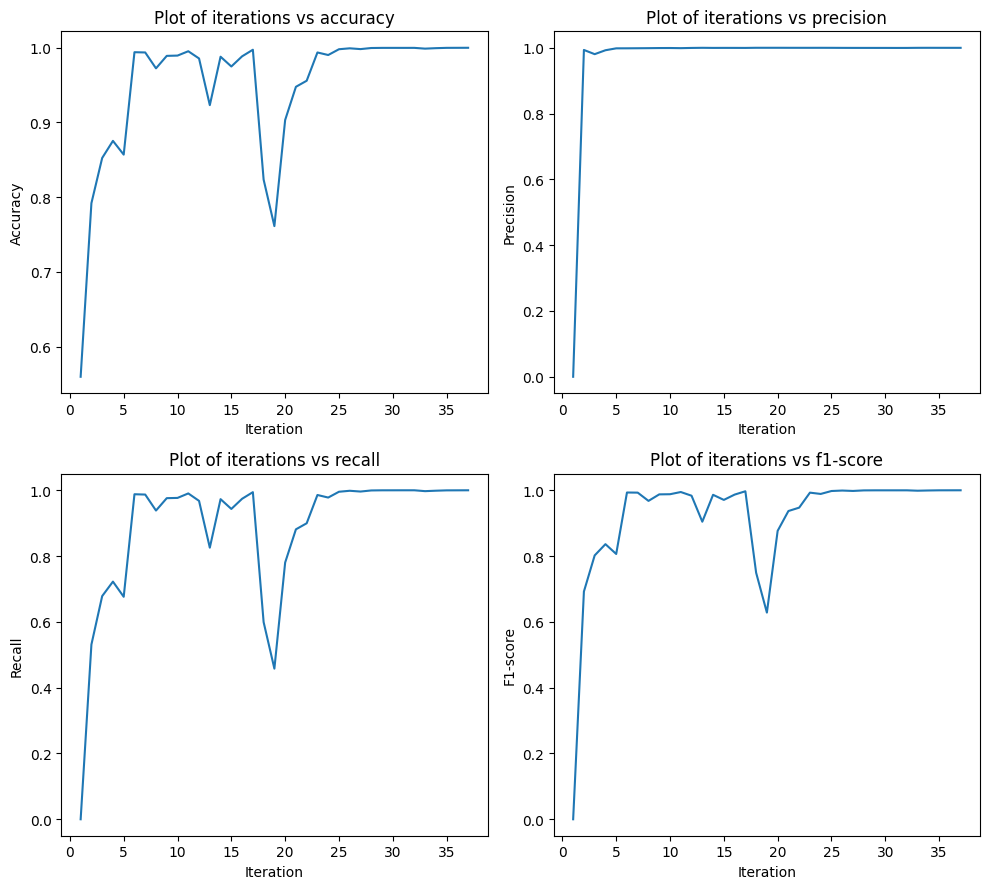

In [17]:
# Plot iteration vs accuracy

plt.figure(figsize=(10, 9))

plt.subplot(2,2,1)
plt.plot(num_it_array, accuracy_array)
plt.title("Plot of iterations vs accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")

# Plot iteration vs precision

plt.subplot(2,2,2)
plt.plot(num_it_array, precision_array)
plt.title("Plot of iterations vs precision")
plt.xlabel("Iteration")
plt.ylabel("Precision")

# Plot iteration vs recall

plt.subplot(2,2,3)
plt.plot(num_it_array, recall_array)
plt.title("Plot of iterations vs recall")
plt.xlabel("Iteration")
plt.ylabel("Recall")

# Plot iteration vs f1-score

plt.subplot(2,2,4)
plt.plot(num_it_array, f1_array)
plt.title("Plot of iterations vs f1-score")
plt.xlabel("Iteration")
plt.ylabel("F1-score")

plt.tight_layout()
plt.savefig("Neural.pdf", bbox_inches = 'tight', dpi = 200, format="pdf")

In [16]:
#Plot the ROC curve

Y_final_pred_prob = model.predict(X_test)

fpr, tpr, thresholds = roc_curve(Y_test, Y_final_pred_prob)

3343/3343 [==============================] - 3s 842us/step


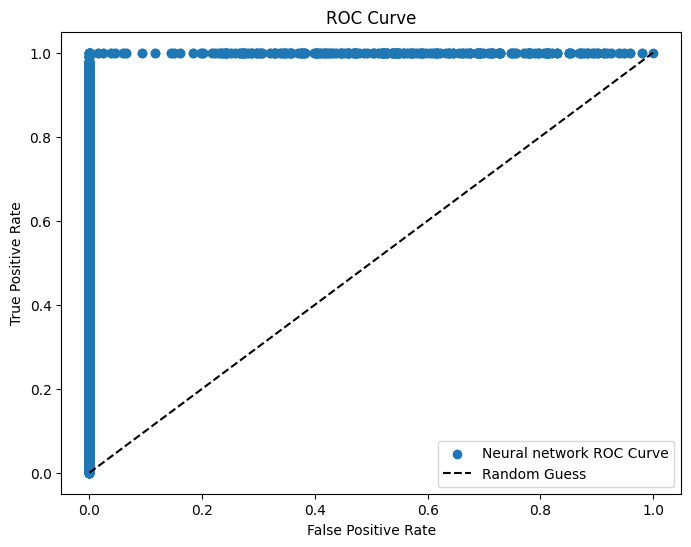

In [17]:
plt.figure(figsize=(8, 6))
plt.scatter(fpr, tpr, label='Neural network ROC Curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

## Checking the model with Live generated points

In [17]:
import Functions as func

In [46]:
#generate new datapoints :- syntax (generate(batch,seed))
points = func.generate(100000,1000)

In [47]:
points = points.values

In [48]:
#check the constraints on the the generated dataset
points_allowed, points_disallowed = func.constraints_check(points)

In [49]:
#create a pandas dataframe of the check dataset
column_names = ['mH1','mH2','mH3','mA1','mA2','mC1','mC2','TanBeta1','TanBeta2','TanAlpha4','TanGamma1','TanGamma2','TanAlpha1','TanAlpha2']

data_disallowed = pd.DataFrame(points_disallowed, columns=column_names)
data_allowed = pd.DataFrame(points_allowed, columns=column_names)
    
#label the dataset
data_allowed['Output'] = 1
data_disallowed['Output'] = 0
    
#merge the dataset
labeled = pd.concat([data_allowed,data_disallowed], ignore_index=True)
    
#extract the X_labeled and Y_labeled
X_new = labeled.drop('Output', axis = 1)
Y_new = labeled['Output']

In [50]:
data_allowed

,mH1,mH2,mH3,mA1,mA2,mC1,mC2,TanBeta1,TanBeta2,TanAlpha4,TanGamma1,TanGamma2,TanAlpha1,TanAlpha2,Output
0,125.0,263.091217,259.126225,271.040733,385.923890,328.433409,208.234237,0.696491,0.596084,27.875966,22.625537,6.828221,0.696491,0.596084,1
1,125.0,228.230829,463.879574,419.955780,235.714879,503.326019,349.807398,0.989784,0.546198,10.706046,19.201450,16.390351,0.989784,0.546198,1


In [34]:
X_new = scaler.transform(X_new)

In [35]:
import time

start_time = time.time()

#Get model predictions on the test data
Y_new_test = model.predict(X_new, verbose=0).ravel()   

end_time = time.time()

elapsed_time = end_time - start_time

print(elapsed_time)

0.32651281356811523


In [45]:
Y_new.sum()

0

In [37]:
np.where(Y_new==1)

(array([], dtype=int64),)

In [38]:
#Convert the predictions into binary
Y_new_binary = (Y_new_test > 0.9).astype(int)

In [39]:
#Calculate accuracy,precision,recall and F1 Score on the test set
accuracy = accuracy_score(Y_new, Y_new_binary)
precision = precision_score(Y_new, Y_new_binary)
recall = recall_score(Y_new, Y_new_binary)
f1 = f1_score(Y_new, Y_new_binary)
frac_labeled = Y_new.sum()/len(Y_new)
print(f"Test Accuracy = {accuracy:.6f}")
print(f"Test Precision = {precision:.6f}")
print(f"Test Recall = {recall:.6f}")
print(f"Test F1 = {f1:.6f}")
print(f"Fraction of allowed points in new dataset = {frac_labeled}")

Test Accuracy = 0.999200
Test Precision = 0.000000
Test Recall = 0.000000
Test F1 = 0.000000
Fraction of allowed points in new dataset = 0.0


/home/akshat/work_env/work_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [40]:
Y_new_binary.sum()

4

In [78]:
np.where(Y_new_binary==1)

(array([     0,   1696,   6426,   8003,   8974,  10797,  17299,  22396,
         24237,  38061,  40284,  46389,  46650,  48306,  51827,  58766,
         60267,  69778,  78409,  78992,  87649,  94525,  95347, 104773,
        105086, 109541, 110854, 114013, 125439, 130062, 130579, 131793,
        134697, 137551, 150649, 162256, 165454, 167711, 167769, 173628,
        174840, 188368, 191179, 191906, 194759, 195614, 202343, 202424,
        204836, 212076, 212439, 213535, 213725, 218247, 218474, 218775,
        219093, 222027, 223297, 228189, 239081, 240297, 244551, 244585,
        244862, 247206, 251394, 252110, 253556, 257447, 267071, 268413,
        272345, 279514, 281014, 289684, 293402, 299732, 303335, 303889,
        303896, 306028, 306398, 307940, 311561, 318538, 320518, 320810,
        323236, 325198, 325820, 330673, 330997, 331995, 338553, 355572,
        361961, 365938, 375002, 377688, 377991, 378025, 378780, 392571,
        393105, 395197, 399032, 401297, 402045, 408172, 419981, 

In [79]:
Y_new_test[0]

0.99772924

## Checking model with new allowed points dataset

In [70]:
#import the csv file containing allowed values

df1 = pd.read_csv('Alignment-1-New.csv')

In [71]:
len(df1)

975

In [72]:
df1['Output'] = 1

In [73]:
#put feature variable to X and target variable to Y

X_new = df1.drop('Output', axis = 1)
Y_new = df1['Output']

In [74]:
X_new = scaler.transform(X_new)

In [75]:
Y_new_test = model.predict(X_new)

31/31 [==============================] - 0s 1ms/step


In [76]:
Y_new_test

array([[0.9760967 ],
       [0.9908964 ],
       [0.99831444],
       [0.9977351 ],
       [0.9995128 ],
       [0.99732673],
       [0.98324686],
       [0.96948403],
       [0.99762815],
       [0.99262345],
       [0.9975933 ],
       [0.9952056 ],
       [0.99945307],
       [0.9972352 ],
       [0.9864471 ],
       [0.99776524],
       [0.99573416],
       [0.9876884 ],
       [0.998919  ],
       [0.99564826],
       [0.9979409 ],
       [0.9987487 ],
       [0.99958867],
       [0.9870348 ],
       [0.97167736],
       [0.9964383 ],
       [0.9992262 ],
       [0.99617934],
       [0.999705  ],
       [0.9861316 ],
       [0.9990619 ],
       [0.99630404],
       [0.9940811 ],
       [0.99506325],
       [0.9977019 ],
       [0.9923436 ],
       [0.9981175 ],
       [0.9905535 ],
       [0.9951794 ],
       [0.9960928 ],
       [0.99031293],
       [0.99453604],
       [0.99415183],
       [0.99617416],
       [0.99708843],
       [0.99293995],
       [0.99457544],
       [0.996

In [93]:
Y_new_binary = (Y_new_test > 0.85).astype(int)

In [94]:
Y_new_binary.sum()

975

In [27]:
#Calculate accuracy,precision,recall and F1 Score on the test set
accuracy = accuracy_score(Y_new, Y_new_binary)
precision = precision_score(Y_new, Y_new_binary)
recall = recall_score(Y_new, Y_new_binary)
f1 = f1_score(Y_new, Y_new_binary)
frac_labeled = Y_new.sum()/len(Y_new)
print(f"Test Accuracy = {accuracy:.6f}")
print(f"Test Precision = {precision:.6f}")
print(f"Test Recall = {recall:.6f}")
print(f"Test F1 = {f1:.6f}")
print(f"Fraction of allowed points in new dataset = {frac_labeled}")

Test Accuracy = 1.000000
Test Precision = 1.000000
Test Recall = 1.000000
Test F1 = 1.000000
Fraction of allowed points in new dataset = 1.0


## Selecting most uncertain points from unlabeled dataset

In [25]:
#selecting the most uncertain indices from the first model

entropy = -Y_pred_unlabel*np.log2(Y_pred_unlabel+1e-30) - (1-Y_pred_unlabel)*np.log2(1-Y_pred_unlabel+1e-30)

num_samples_to_select = 2
    
selected_indices = np.argsort(entropy)[-num_samples_to_select:]

In [26]:
selected_indices

array([8000, 2710])

In [27]:
np.where(Y_unlabeled.iloc[selected_indices]==1)

(array([0]),)

In [28]:
#Retrieve the selected rows for the second neural network

X_train_2 = X_unlabeled.iloc[selected_indices]
Y_train_2 = Y_unlabeled.iloc[selected_indices]

In [29]:
#concatenate X and Y train
combined = pd.concat([X_train_2, Y_train_2],axis=1)

In [30]:
#Iterate over each row in X_train_2 and Y_train_2 and find the indices
indices_to_remove = []
for index, row in X_train_2.iterrows():
    indices_to_remove.extend(combined[combined[X.columns].eq(row.to_dict()).all(1)].index)

In [31]:
indices_to_remove

[35078, 15514]

In [32]:
#drop these indices in the total dataset
X = X.drop(indices_to_remove)
Y = Y.drop(indices_to_remove)

In [35]:
#Split into train data and test data

X_unlabeled, X_test, Y_unlabeled, Y_test = train_test_split(X, Y, test_size = 0.92, random_state = 42)

X_labeled = X_train_2
Y_labeled = Y_train_2

In [36]:
print(f"Total Number of datapoints: {len(X)}")
print(f"Number of labeled datapoints: {len(X_labeled)}")
print(f"Number of unlabeled datapoints: {len(X_unlabeled)}")
print(f"Number of test datapoints: {len(X_test)}")

Total Number of datapoints: 102573
Number of labeled datapoints: 2
Number of unlabeled datapoints: 8205
Number of test datapoints: 94368


In [37]:
frac_unlabeled = Y_unlabeled.sum()/len(Y_unlabeled)
frac_labeled = Y_labeled.sum()/len(Y_labeled)
frac_test = Y_test.sum()/len(Y_test)

In [38]:
print(f"Fraction of allowed points in labeled dataset: {frac_labeled}")
print(f"Fraction of allowed points in unlabeled dataset: {frac_unlabeled}")
print(f"Fraction of allowed points in test dataset: {frac_test}")

Fraction of allowed points in labeled dataset: 0.5
Fraction of allowed points in unlabeled dataset: 0.493235831809872
Fraction of allowed points in test dataset: 0.5004662597490674


## Neural Network Model 2

In [39]:
# Set random seeds for reproducibility
seed_value = 42
tf.random.set_seed(seed_value)
np.random.seed(seed_value)

In [40]:
#define your model
model_2 = keras.Sequential()

# Add input layer with 14 input parameters
model_2.add(layers.Input(shape=(X.shape[1],)))

model_2.add(layers.Dense(128, kernel_regularizer=l2(0.001)))
model_2.add(layers.BatchNormalization())
model_2.add(layers.Activation('relu'))
model_2.add(layers.Dropout(0.6))

model_2.add(layers.Dense(32, kernel_regularizer=l2(0.001)))
model_2.add(layers.BatchNormalization())
model_2.add(layers.Activation('relu'))
model_2.add(layers.Dropout(0.6))

model_2.add(layers.Dense(64, kernel_regularizer=l2(0.001)))
model_2.add(layers.BatchNormalization())
model_2.add(layers.Activation('relu'))
model_2.add(layers.Dropout(0.6))

model_2.add(layers.Dense(32, kernel_regularizer=l2(0.001)))
model_2.add(layers.BatchNormalization())
model_2.add(layers.Activation('relu'))
model_2.add(layers.Dropout(0.6))

model_2.add(layers.Dense(1, activation = 'sigmoid'))

custom_learning_rate = 0.001  # You can adjust this value as needed

# Compile the model with a custom learning rate
custom_optimizer = tf.keras.optimizers.Adam(learning_rate=custom_learning_rate)
model_2.compile(loss='binary_crossentropy', optimizer=custom_optimizer)

# Display the model summary to see the architecture
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 128)               1920      
                                                                 
 batch_normalization_3 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 activation_3 (Activation)   (None, 128)               0         
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 32)                4128      
                                                                 
 batch_normalization_4 (Bat  (None, 32)                128       
 chNormalization)                                     

## Active Learning Loop

In [41]:
#active learning loop
num_iterations = 40

num_it_array = np.arange(1,num_iterations+2,1)
accuracy_array = np.zeros(num_iterations+1)
precision_array = np.zeros(num_iterations+1)
recall_array = np.zeros(num_iterations+1)
f1_array = np.zeros(num_iterations+1)

for iteration in range(num_iterations):
    #Train the model
    model_2.fit(X_labeled,Y_labeled, epochs=150, batch_size=32, verbose=0)
    
    #Get model predictions on the test data
    Y_pred_test = model_2.predict(X_test, verbose=0).ravel()   
    
    #Convert the predictions into binary
    Y_pred_binary = (Y_pred_test > 0.5).astype(int)
    
    #Calculate accuracy,precision,recall and F1 Score on the test set
    accuracy = accuracy_score(Y_test, Y_pred_binary)
    accuracy_array[iteration] = accuracy
    precision = precision_score(Y_test, Y_pred_binary)
    precision_array[iteration] = precision
    recall = recall_score(Y_test, Y_pred_binary)
    recall_array[iteration] = recall
    f1 = f1_score(Y_test, Y_pred_binary)
    f1_array[iteration] = f1
    frac_labeled = Y_labeled.sum()/len(Y_labeled)
    print(f"Iteration : {iteration + 1}: Test Accuracy = {accuracy:.6f}")
    print(f"Iteration : {iteration + 1}: Test Precision = {precision:.6f}")
    print(f"Iteration : {iteration + 1}: Test Recall = {recall:.6f}")
    print(f"Iteration : {iteration + 1}: Test F1 = {f1:.6f}")
    print(f"Iteration : {iteration + 1}: Fraction of allowed points in labeled dataset = {frac_labeled}")
    print(" ") #Print a blank line
    
    #Get model predictions on the unlabeled data
    Y_pred_unlabel = model_2.predict(X_unlabeled, verbose=0).ravel()
    
    #Calculate entropy
    entropy = -Y_pred_unlabel*np.log2(Y_pred_unlabel+1e-30) - (1-Y_pred_unlabel)*np.log2(1-Y_pred_unlabel+1e-30)
    
    #Select the most uncertain samples
    num_samples_to_label = 2
    selected_indices = np.argsort(entropy)[-num_samples_to_label:]
    
    #move the selected samples from unlabeled to labeled data
    X_labeled = pd.concat([X_labeled, X_unlabeled.iloc[selected_indices]])
    Y_labeled = pd.concat([Y_labeled, pd.Series(Y_unlabeled.iloc[selected_indices])])
    
    #Remove the newly labeled samples from the unlabeled data
    X_unlabeled = X_unlabeled.drop(X_unlabeled.index[selected_indices])
    Y_unlabeled = Y_unlabeled.drop(Y_unlabeled.index[selected_indices])
    
#Train the final model on all labeled data 
model_2.fit(X_labeled,Y_labeled, epochs=150, batch_size=32, verbose=0)

#Evaluate the final model on the test data
Y_pred_test = model_2.predict(X_test, verbose=0).ravel()   
    
#Convert the predictions into binary
Y_pred_binary = (Y_pred_test > 0.5).astype(int)

#Calculate various metric scores
final_accuracy = accuracy_score(Y_test, Y_pred_binary)
accuracy_array[-1] = final_accuracy
final_precision = precision_score(Y_test, Y_pred_binary)
precision_array[-1] = final_precision
final_recall = recall_score(Y_test, Y_pred_binary)
recall_array[-1] = final_recall
final_f1 = f1_score(Y_test, Y_pred_binary)
f1_array[-1] = final_f1
frac_labeled = Y_labeled.sum()/len(Y_labeled)

print(f"Final Model Test Accuracy: {final_accuracy:.6f}")
print(f"Final Model Test Precision: {final_precision:.6f}")
print(f"Final Model Test Recall: {final_recall:.6f}")
print(f"Final Model Test F1: {final_f1:.6f}")
print(f"Fraction of allowed points in labeled dataset: {frac_labeled}")

Iteration : 1: Test Accuracy = 0.716482
Iteration : 1: Test Precision = 0.641723
Iteration : 1: Test Recall = 0.981431
Iteration : 1: Test F1 = 0.776028
Iteration : 1: Fraction of allowed points in labeled dataset = 0.5
 
Iteration : 2: Test Accuracy = 0.732833
Iteration : 2: Test Precision = 0.825565
Iteration : 2: Test Recall = 0.591048
Iteration : 2: Test F1 = 0.688894
Iteration : 2: Fraction of allowed points in labeled dataset = 0.25
 
Iteration : 3: Test Accuracy = 0.879981
Iteration : 3: Test Precision = 0.895640
Iteration : 3: Test Recall = 0.860443
Iteration : 3: Test F1 = 0.877689
Iteration : 3: Fraction of allowed points in labeled dataset = 0.3333333333333333
 
Iteration : 4: Test Accuracy = 0.923014
Iteration : 4: Test Precision = 0.867300
Iteration : 4: Test Recall = 0.999026
Iteration : 4: Test F1 = 0.928514
Iteration : 4: Fraction of allowed points in labeled dataset = 0.5
 
Iteration : 5: Test Accuracy = 0.949051
Iteration : 5: Test Precision = 0.907602
Iteration : 5: 

Text(0, 0.5, 'F1-score')

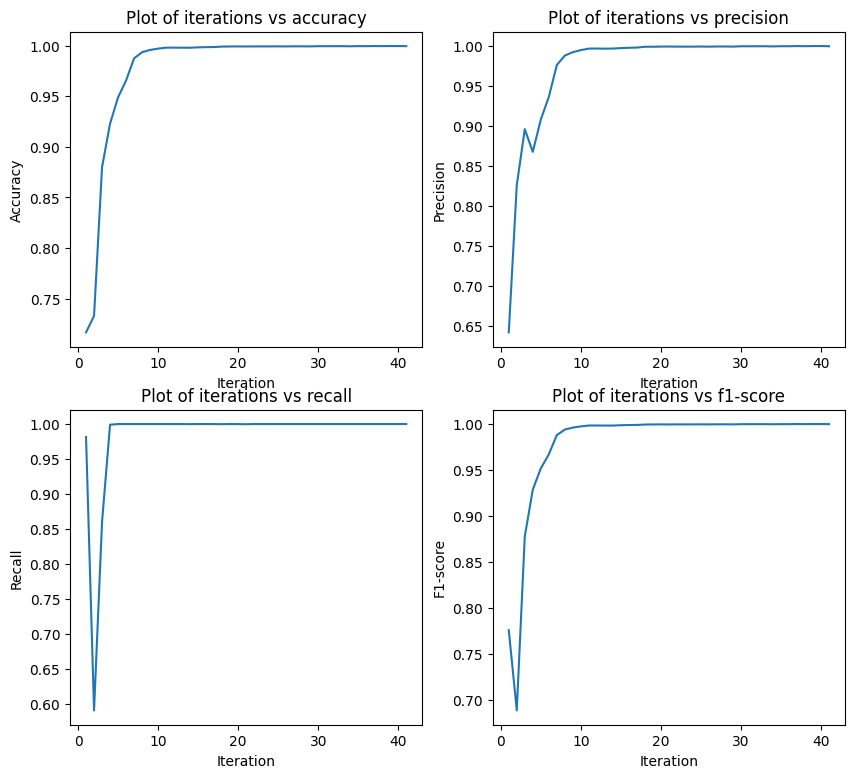

In [42]:
# Plot iteration vs accuracy

plt.figure(figsize=(10, 9))

plt.subplot(2,2,1)
plt.plot(num_it_array, accuracy_array)
plt.title("Plot of iterations vs accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")

# Plot iteration vs precision

plt.subplot(2,2,2)
plt.plot(num_it_array, precision_array)
plt.title("Plot of iterations vs precision")
plt.xlabel("Iteration")
plt.ylabel("Precision")

# Plot iteration vs recall

plt.subplot(2,2,3)
plt.plot(num_it_array, recall_array)
plt.title("Plot of iterations vs recall")
plt.xlabel("Iteration")
plt.ylabel("Recall")

# Plot iteration vs f1-score

plt.subplot(2,2,4)
plt.plot(num_it_array, f1_array)
plt.title("Plot of iterations vs f1-score")
plt.xlabel("Iteration")
plt.ylabel("F1-score")

## Using Sinc Activation Function

In [13]:
def sinc_activation(x):
    return tf.where(tf.equal(x, 0), tf.ones_like(x), tf.sin(x) / x)

In [14]:
#define your model
model = keras.Sequential()

# Add input layer with 14 input parameters
model.add(layers.Input(shape=(X.shape[1],)))

model.add(layers.Dense(128, kernel_regularizer=l2(0.001)))
#model.add(layers.BatchNormalization())
model.add(layers.Activation(sinc_activation))
#model.add(layers.Dropout(0.5))

model.add(layers.Dense(32, kernel_regularizer=l2(0.001)))
#model.add(layers.BatchNormalization())
model.add(layers.Activation(sinc_activation))
#model.add(layers.Dropout(0.5))

model.add(layers.Dense(64, kernel_regularizer=l2(0.001)))
#model.add(layers.BatchNormalization())
model.add(layers.Activation(sinc_activation))
#model.add(layers.Dropout(0.5))

model.add(layers.Dense(1, activation = 'sigmoid'))

custom_learning_rate = 0.001  # You can adjust this value as needed

# Compile the model with a custom learning rate
custom_optimizer = tf.keras.optimizers.Adam(learning_rate=custom_learning_rate)
model.compile(loss='binary_crossentropy', optimizer=custom_optimizer)

# Display the model summary to see the architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1920      
                                                                 
 activation (Activation)     (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 32)                4128      
                                                                 
 activation_1 (Activation)   (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 64)                2112      
                                                                 
 activation_2 (Activation)   (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 6

In [15]:
#active learning loop
num_iterations = 40

num_it_array = np.arange(1,num_iterations+2,1)
accuracy_array = np.zeros(num_iterations+1)
precision_array = np.zeros(num_iterations+1)
recall_array = np.zeros(num_iterations+1)
f1_array = np.zeros(num_iterations+1)

for iteration in range(num_iterations):
    #Train the model
    model.fit(X_labeled,Y_labeled, epochs=150, batch_size=32, verbose=0)
    
    #Get model predictions on the test data
    Y_pred_test = model.predict(X_test, verbose=0).ravel()   
    
    #Convert the predictions into binary
    Y_pred_binary = (Y_pred_test > 0.5).astype(int)
    
    #Calculate accuracy,precision,recall and F1 Score on the test set
    accuracy = accuracy_score(Y_test, Y_pred_binary)
    accuracy_array[iteration] = accuracy
    precision = precision_score(Y_test, Y_pred_binary)
    precision_array[iteration] = precision
    recall = recall_score(Y_test, Y_pred_binary)
    recall_array[iteration] = recall
    f1 = f1_score(Y_test, Y_pred_binary)
    f1_array[iteration] = f1
    frac_labeled = Y_labeled.sum()/len(Y_labeled)
    print(f"Iteration : {iteration + 1}: Test Accuracy = {accuracy:.6f}")
    print(f"Iteration : {iteration + 1}: Test Precision = {precision:.6f}")
    print(f"Iteration : {iteration + 1}: Test Recall = {recall:.6f}")
    print(f"Iteration : {iteration + 1}: Test F1 = {f1:.6f}")
    print(f"Iteration : {iteration + 1}: Fraction of allowed points in labeled dataset = {frac_labeled}")
    print(" ") #Print a blank line
    
    #Get model predictions on the unlabeled data
    Y_pred_unlabel = model.predict(X_unlabeled, verbose=0).ravel()
    
    #Calculate entropy
    entropy = -Y_pred_unlabel*np.log2(Y_pred_unlabel+1e-30) - (1-Y_pred_unlabel)*np.log2(1-Y_pred_unlabel+1e-30)
    
    #Select the most uncertain samples
    num_samples_to_label = 2
    selected_indices = np.argsort(entropy)[-num_samples_to_label:]
    
    #move the selected samples from unlabeled to labeled data
    X_labeled = pd.concat([X_labeled, X_unlabeled.iloc[selected_indices]])
    Y_labeled = pd.concat([Y_labeled, pd.Series(Y_unlabeled.iloc[selected_indices])])
    
    #Remove the newly labeled samples from the unlabeled data
    X_unlabeled = X_unlabeled.drop(X_unlabeled.index[selected_indices])
    Y_unlabeled = Y_unlabeled.drop(Y_unlabeled.index[selected_indices])
    
#Train the final model on all labeled data 
model.fit(X_labeled,Y_labeled, epochs=150, batch_size=32, verbose=0)

#Evaluate the final model on the test data
Y_pred_test = model.predict(X_test, verbose=0).ravel()   
    
#Convert the predictions into binary
Y_pred_binary = (Y_pred_test > 0.5).astype(int)

#Calculate various metric scores
final_accuracy = accuracy_score(Y_test, Y_pred_binary)
accuracy_array[-1] = final_accuracy
final_precision = precision_score(Y_test, Y_pred_binary)
precision_array[-1] = final_precision
final_recall = recall_score(Y_test, Y_pred_binary)
recall_array[-1] = final_recall
final_f1 = f1_score(Y_test, Y_pred_binary)
f1_array[-1] = final_f1
frac_labeled = Y_labeled.sum()/len(Y_labeled)

print(f"Final Model Test Accuracy: {final_accuracy:.6f}")
print(f"Final Model Test Precision: {final_precision:.6f}")
print(f"Final Model Test Recall: {final_recall:.6f}")
print(f"Final Model Test F1: {final_f1:.6f}")
print(f"Fraction of allowed points in labeled dataset: {frac_labeled}")

Iteration : 1: Test Accuracy = 0.511333
Iteration : 1: Test Precision = 0.505607
Iteration : 1: Test Recall = 1.000000
Iteration : 1: Test F1 = 0.671632
Iteration : 1: Fraction of allowed points in labeled dataset = 0.5
 
Iteration : 2: Test Accuracy = 0.611832
Iteration : 2: Test Precision = 0.562834
Iteration : 2: Test Recall = 1.000000
Iteration : 2: Test F1 = 0.720274
Iteration : 2: Fraction of allowed points in labeled dataset = 0.25
 
Iteration : 3: Test Accuracy = 0.804459
Iteration : 3: Test Precision = 0.728939
Iteration : 3: Test Recall = 0.969085
Iteration : 3: Test F1 = 0.832030
Iteration : 3: Fraction of allowed points in labeled dataset = 0.16666666666666666
 
Iteration : 4: Test Accuracy = 0.819761
Iteration : 4: Test Precision = 0.734946
Iteration : 4: Test Recall = 0.999979
Iteration : 4: Test F1 = 0.847219
Iteration : 4: Fraction of allowed points in labeled dataset = 0.25
 
Iteration : 5: Test Accuracy = 0.985451
Iteration : 5: Test Precision = 0.971847
Iteration : 5

Text(0, 0.5, 'F1-score')

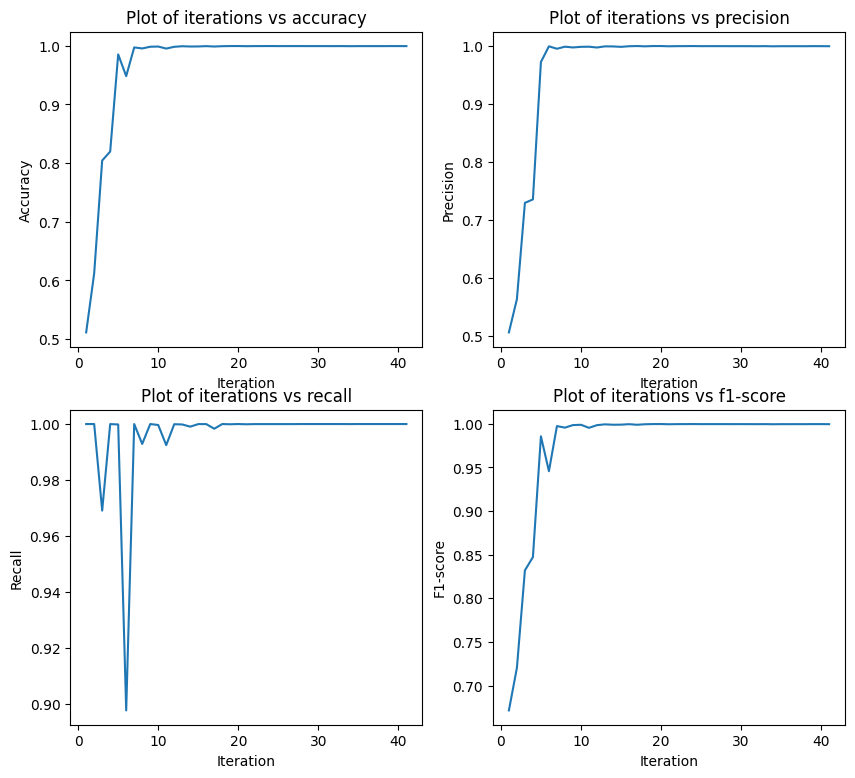

In [16]:
# Plot iteration vs accuracy

plt.figure(figsize=(10, 9))

plt.subplot(2,2,1)
plt.plot(num_it_array, accuracy_array)
plt.title("Plot of iterations vs accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")

# Plot iteration vs precision

plt.subplot(2,2,2)
plt.plot(num_it_array, precision_array)
plt.title("Plot of iterations vs precision")
plt.xlabel("Iteration")
plt.ylabel("Precision")

# Plot iteration vs recall

plt.subplot(2,2,3)
plt.plot(num_it_array, recall_array)
plt.title("Plot of iterations vs recall")
plt.xlabel("Iteration")
plt.ylabel("Recall")

# Plot iteration vs f1-score

plt.subplot(2,2,4)
plt.plot(num_it_array, f1_array)
plt.title("Plot of iterations vs f1-score")
plt.xlabel("Iteration")
plt.ylabel("F1-score")